<a href="https://colab.research.google.com/github/davidjcox333/Man-vs-Machine/blob/master/NOLA_ML_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Packages!!
import os
import sys
import pandas as pd
import numpy as np
import scipy
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, auc
drive.mount('/content/gdrive')
%cd './gdrive/My Drive/Policing Data'
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Policing Data


In [4]:
# Read in the data
raw_data = pd.read_csv("la_new_orleans_2020_04_01.csv")
data = raw_data.copy()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,6,13,14,15,20,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data pre-processing

In [5]:
# Sample of what the data looks like and the data types
print(data.dtypes)
data.head()

raw_row_number         object
date                   object
time                   object
location               object
lat                   float64
lng                   float64
district               object
zone                   object
subject_age           float64
subject_race           object
subject_sex            object
officer_assignment     object
type                   object
arrest_made            object
citation_issued        object
warning_issued         object
outcome                object
contraband_found       object
contraband_drugs       object
contraband_weapons     object
frisk_performed        object
search_conducted       object
search_person          object
search_vehicle         object
search_basis           object
reason_for_stop        object
vehicle_color          object
vehicle_make           object
vehicle_model          object
vehicle_year          float64
raw_actions_taken      object
raw_subject_race       object
dtype: object


,raw_row_number,date,time,location,lat,lng,district,zone,subject_age,subject_race,subject_sex,officer_assignment,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,search_basis,reason_for_stop,vehicle_color,vehicle_make,vehicle_model,vehicle_year,raw_actions_taken,raw_subject_race
0,1,2010-01-01,01:11:00,NaN,NaN,NaN,6,E,26.0,black,female,6th District,vehicular,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,TRAFFIC VIOLATION,BLACK,DODGE,CARAVAN,2005.0,NaN,BLACK
1,9087,2010-01-01,01:29:00,NaN,NaN,NaN,7,C,37.0,black,male,7th District,vehicular,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,TRAFFIC VIOLATION,BLUE,NISSAN,MURANO,2005.0,NaN,BLACK
2,9086,2010-01-01,01:29:00,NaN,NaN,NaN,7,C,37.0,black,male,7th District,vehicular,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,TRAFFIC VIOLATION,BLUE,NISSAN,MURANO,2005.0,NaN,BLACK
3,267,2010-01-01,14:00:00,NaN,NaN,NaN,7,I,96.0,black,male,7th District,vehicular,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,TRAFFIC VIOLATION,GRAY,JEEP,GRAND CHEROKEE,2003.0,NaN,BLACK
4,2,2010-01-01,02:06:00,NaN,NaN,NaN,5,D,17.0,black,male,5th District,NaN,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,CALL FOR SERVICE,NaN,NaN,NaN,NaN,NaN,BLACK


In [39]:
# Isolate the columns we're interested in. 
df = data[['date', 'time','location','lat','lng','district',\
                'zone','subject_age','subject_race',\
                'subject_sex','officer_assignment','type',\
                'arrest_made','citation_issued','warning_issued', \
                'contraband_found','contraband_drugs',\
                'contraband_weapons','frisk_performed','search_conducted',\
                'search_person','search_vehicle','search_basis', 'reason_for_stop',\
                'vehicle_color', 'vehicle_make', 'vehicle_model', 'vehicle_year']]

In [10]:
df.head()

,date,time,location,lat,lng,district,zone,subject_age,subject_race,subject_sex,officer_assignment,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,frisk_performed,search_conducted,search_person,search_vehicle,search_basis,reason_for_stop,vehicle_color,vehicle_make,vehicle_model,vehicle_year
0,2010-01-01,01:11:00,NaN,NaN,NaN,6,E,26.0,black,female,6th District,vehicular,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,TRAFFIC VIOLATION,BLACK,DODGE,CARAVAN,2005.0
1,2010-01-01,01:29:00,NaN,NaN,NaN,7,C,37.0,black,male,7th District,vehicular,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,TRAFFIC VIOLATION,BLUE,NISSAN,MURANO,2005.0
2,2010-01-01,01:29:00,NaN,NaN,NaN,7,C,37.0,black,male,7th District,vehicular,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,TRAFFIC VIOLATION,BLUE,NISSAN,MURANO,2005.0
3,2010-01-01,14:00:00,NaN,NaN,NaN,7,I,96.0,black,male,7th District,vehicular,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,TRAFFIC VIOLATION,GRAY,JEEP,GRAND CHEROKEE,2003.0
4,2010-01-01,02:06:00,NaN,NaN,NaN,5,D,17.0,black,male,5th District,NaN,False,False,False,NaN,NaN,NaN,NaN,False,False,False,False,NaN,CALL FOR SERVICE,NaN,NaN,NaN,NaN


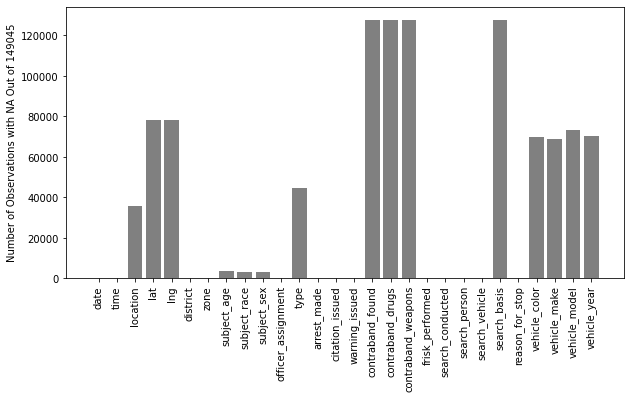

In [40]:
# Count the number of nan per feature. 
data_cols = list(df)
col_nan = []
for i in data_cols:
    val = df[i].isna().sum()
    col_nan.append(val)

# Plot the number of nan per feature
height = col_nan
bars = list(df)
y_pos = np.arange(len(bars))

f, ax = plt.subplots(figsize=(10, 5))
plt.bar(y_pos, height, color='grey')
plt.xticks(y_pos, bars, rotation=90) # Rotation of the bars names
plt.ylabel("Number of Observations with NA Out of %s" %len(df))
plt.show() # Show graphic

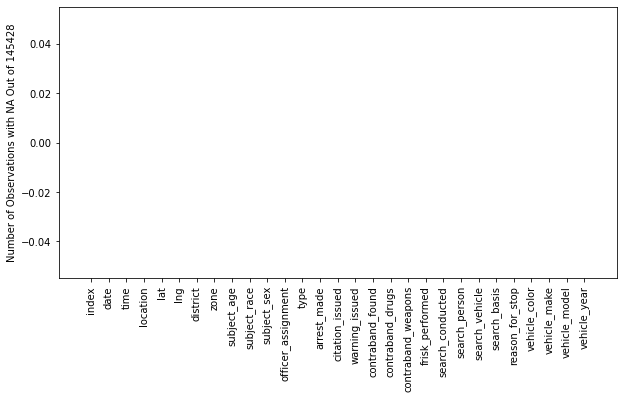

In [42]:
# Manage NaN values by different column data type
import warnings
warnings.simplefilter('ignore')

df['location'] = df['location'].fillna('unknown') 
df['lat'] = df['lat'].fillna(df.lat.mean()) 
df['lng'] = df['lng'].fillna(df.lng.mean()) 
df['type'] = df['type'].fillna('unknown') 
df['contraband_found'] = df['contraband_found'].fillna(0)
df['contraband_drugs'] = df['contraband_drugs'].fillna(0)
df['contraband_weapons'] = df['contraband_weapons'].fillna(0)
df['search_basis'] = df['search_basis'].fillna('unknown')
df['vehicle_color'] = df['vehicle_color'].fillna('unknown')
df['vehicle_make'] = df['vehicle_make'].fillna('unknown')
df['vehicle_model'] = df['vehicle_model'].fillna('unknown')
df['vehicle_year'] = df['vehicle_year'].fillna(2004)
df = df.dropna() # Drop remaining rows with NaN
df = df.reset_index()

# Show that all are zero now
data_cols = list(df)
col_nan = []
for i in data_cols:
    val = df[i].isna().sum()
    col_nan.append(val)

# Plot the number of nan per feature
height = col_nan
bars = list(df)
y_pos = np.arange(len(bars))

f, ax = plt.subplots(figsize=(10, 5))
plt.bar(y_pos, height, color='grey')
plt.xticks(y_pos, bars, rotation=90) # Rotation of the bars names
plt.ylabel("Number of Observations with NA Out of %s" %len(df))
plt.show() # Show graphic

In [43]:
# Recode categorical variables as numerical
cat_cols = ['location', 'district', 'zone', 'subject_race', 'subject_sex', \
            'officer_assignment', 'type', 'search_basis', 'reason_for_stop', \
            'vehicle_color', 'vehicle_make', 'vehicle_model']

for i in cat_cols:
  df[i] = df[i].astype('category')
  df[i] = df[i].cat.codes

In [44]:
# Convert date column to separate numerical month and year columns
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [45]:
# Convert time column to numerical value
import datetime
df['time'] = df['time'].astype(str)

seconds = []

def get_sec(time_str):
  h, m, s = time_str.split(':')
  return (int(h)*3600) + (int(m)*60) + int(s)

for i in list(range(len(df))):
  val = get_sec(df['time'][i])
  seconds.append(val)

df['seconds'] = seconds
df['hour'] = df['seconds']/3600

In [46]:
# Drop date and time columns
df= df.drop(['index', 'date', 'time', 'seconds'], axis=1)

In [47]:
df.dtypes

location                int16
lat                   float64
lng                   float64
district                 int8
zone                     int8
subject_age           float64
subject_race             int8
subject_sex              int8
officer_assignment       int8
type                     int8
arrest_made            object
citation_issued        object
warning_issued         object
contraband_found       object
contraband_drugs       object
contraband_weapons     object
frisk_performed        object
search_conducted       object
search_person          object
search_vehicle         object
search_basis             int8
reason_for_stop          int8
vehicle_color            int8
vehicle_make             int8
vehicle_model           int16
vehicle_year          float64
year                    int64
month                   int64
hour                  float64
dtype: object

In [48]:
# Turn all true/false columns into 1s and 0s
binary_cols = ['arrest_made', 'citation_issued', 'warning_issued', \
               'contraband_found', 'contraband_drugs', 'contraband_weapons', \
               'frisk_performed', 'search_conducted', 'search_person', \
               'search_vehicle']

for i in binary_cols:
  df[i] = df[i].replace(True, 1)
  df[i] = df[i].replace(False, 0)

In [49]:
# Check data types - should all be ints
print(df.dtypes)

location                int16
lat                   float64
lng                   float64
district                 int8
zone                     int8
subject_age           float64
subject_race             int8
subject_sex              int8
officer_assignment       int8
type                     int8
arrest_made             int64
citation_issued         int64
warning_issued          int64
contraband_found        int64
contraband_drugs        int64
contraband_weapons      int64
frisk_performed         int64
search_conducted        int64
search_person           int64
search_vehicle          int64
search_basis             int8
reason_for_stop          int8
vehicle_color            int8
vehicle_make             int8
vehicle_model           int16
vehicle_year          float64
year                    int64
month                   int64
hour                  float64
dtype: object


In [50]:
# Save df for future analysesdf.
df.to_csv('nola_data_for_ml.csv')

# Create feature and outcome dfs; scale features

In [ ]:
# If starting fresh here, load data
data = pd.read_csv('nola_data_for_ml.csv')
df = data.copy()
df = df.drop(['Unnamed: 0'], axis=1)

In [55]:
# Create dataframes
targets = ['arrest_made','citation_issued','warning_issued','contraband_found',\
            'contraband_drugs','contraband_weapons','frisk_performed',\
            'search_conducted','search_person','search_vehicle']
features = df.drop(targets, axis=1)
outcomes = df.loc[:, targets].values
outcomes = pd.DataFrame(outcomes)
outcomes.columns = targets

In [56]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler
feats_rescaled = MinMaxScaler().fit_transform(features)

# Label columns of rescaled features
feats_rescaled = pd.DataFrame(feats_rescaled)
fr_cols = list(features)
feats_rescaled.columns = fr_cols

# Machine Learning Classification Predictions

In [57]:
# Packages we'll be using
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [58]:
# Define functions
def bin_metrics(x, y):
    '''Prints four common metrics for evaluating classification predictions.'''
    print('Accuracy:', round(metrics.accuracy_score(x, y), 4))
    print('Precision:', round(metrics.precision_score(x, y, average='weighted'), 4))
    print('Recall:', round(metrics.recall_score(x, y, average='weighted'), 4))
    print('F1:', round(metrics.f1_score(x, y, average='weighted'), 4))

def plot_cm(x, y, title):
    '''Plots a confusion matrix.'''
    plt.subplots(figsize=(6, 5))
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20}, fmt='g')# font size
    plt.ylim([0, 2])
    plt.title(title, fontsize=20)
    plt.xlabel('Predicted', fontsize=30)
    plt.ylabel('Observed', fontsize=30)
    print("\n")

## Logistic Regression

In [59]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

def log_reg(outcome_variable):
  X_train, X_test, y_train, y_test = train_test_split(feats_rescaled, outcome_variable, test_size=0.20, random_state = 8675309)
  classifier = LogisticRegression(solver='liblinear')
  classifier.fit(X_train, y_train)
  feat_weights = classifier.coef_
  y_pred = classifier.predict(X_test)
  return y_test, y_pred, feat_weights

Citations Issued:
Accuracy: 0.7525
Precision: 0.7168
Recall: 0.7525
F1: 0.711




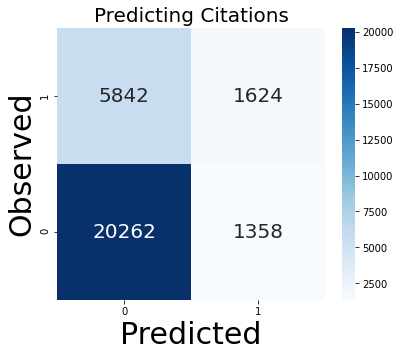

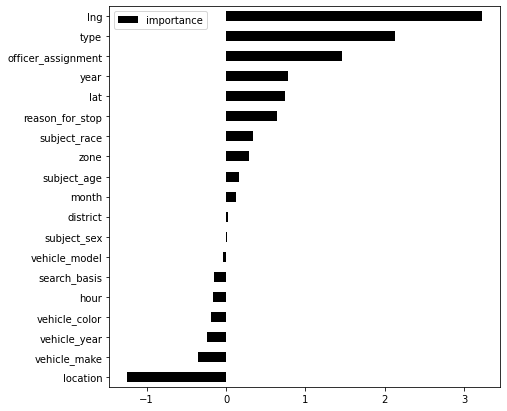

In [60]:
# Predicting citations
print("Citations Issued:")
cites_test, cites_pred, cites_weights = log_reg(outcomes['citation_issued'])
bin_metrics(cites_test, cites_pred)
plot_cm(cites_test, cites_pred, 'Predicting Citations')
cites_weights = cites_weights[0]
feature_importances = pd.DataFrame(cites_weights, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))



Frisks:
Accuracy: 0.9358
Precision: 0.9334
Recall: 0.9358
F1: 0.9342




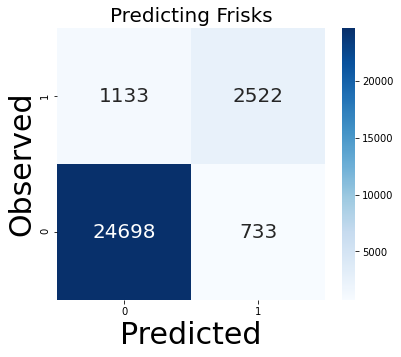

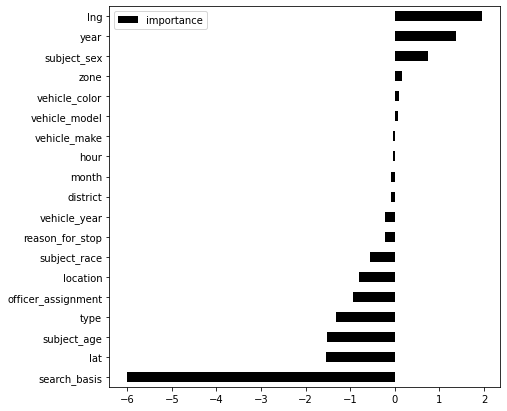

In [61]:
# Predicting Frisks
print("\n\nFrisks:")
frisk_test, frisk_pred, frisk_weights = log_reg(outcomes['frisk_performed'])
bin_metrics(frisk_test, frisk_pred)
plot_cm(frisk_test, frisk_pred, 'Predicting Frisks')
frisk_weights = frisk_weights[0]
feature_importances = pd.DataFrame(frisk_weights, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))



Searches:
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1: 0.9999




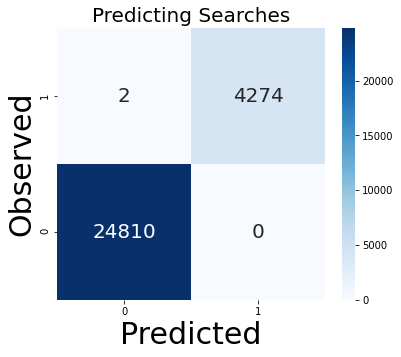

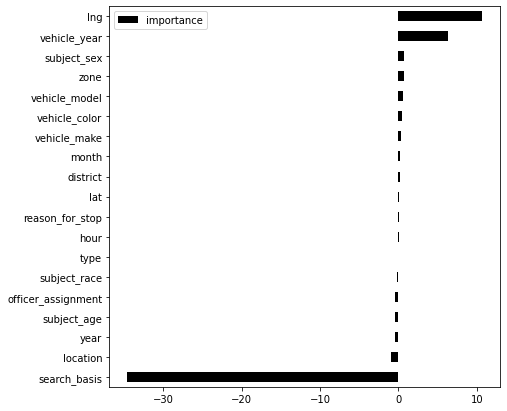

In [63]:
# Predicting Searches
print("\n\nSearches:")
search_test, search_pred, search_weights = log_reg(outcomes['search_conducted'])
bin_metrics(search_test, search_pred)
plot_cm(search_test, search_pred, 'Predicting Searches')
search_weights = search_weights[0]
feature_importances = pd.DataFrame(search_weights, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))



Contraband Found:
Accuracy: 0.9691
Precision: 0.9508
Recall: 0.9691
F1: 0.957




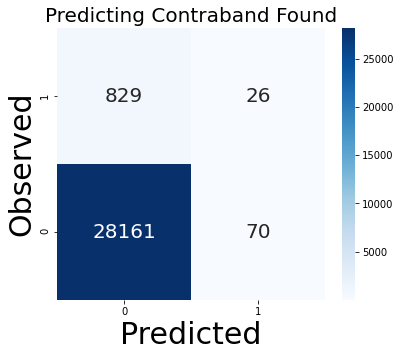

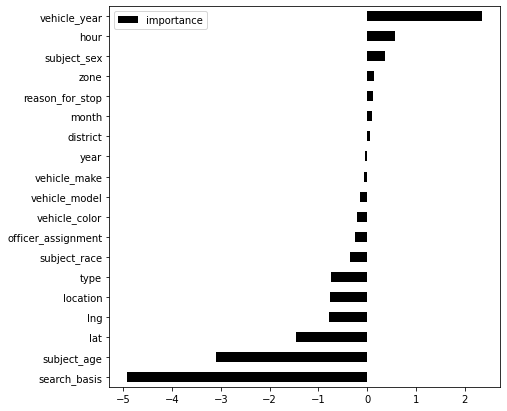

In [64]:
# Predicting Contraband Found
print("\n\nContraband Found:")
contra_test, contra_pred, contra_weights = log_reg(outcomes['contraband_found'])
bin_metrics(contra_test, contra_pred)
plot_cm(contra_test, contra_pred, 'Predicting Contraband Found')
contra_weights = contra_weights[0]
feature_importances = pd.DataFrame(contra_weights, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

## Random Forest

In [65]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

def rand_for(outcome_variable, num_ests, mx_dpth):
  X_train, X_test, y_train, y_test = train_test_split(feats_rescaled, outcome_variable, test_size=0.20, random_state = 649)
  classifier = RandomForestClassifier(n_estimators=num_ests, max_depth=mx_dpth)
  classifier.fit(X_train, y_train)
  feat_weights = classifier.feature_importances_
  y_pred = classifier.predict(X_test)
  return y_test, y_pred, feat_weights

Citations Issued:
Accuracy: 0.8423
Precision: 0.8352
Recall: 0.8423
F1: 0.8353




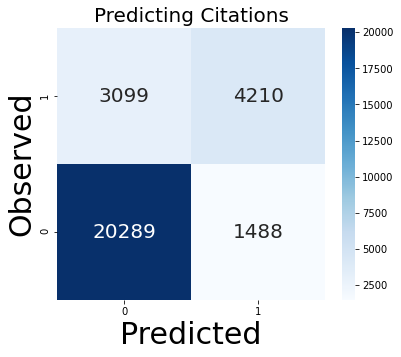

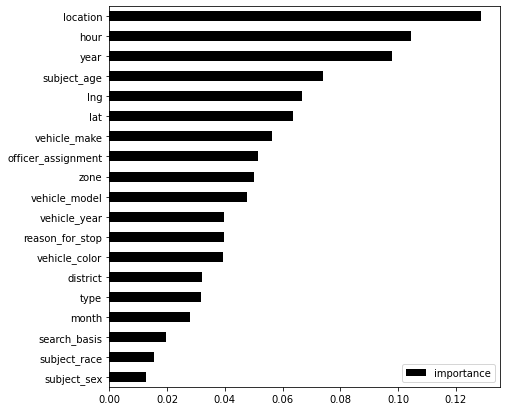

In [66]:
print("Citations Issued:")
citest_test, cites_pred, feat_imp = rand_for(outcomes['citation_issued'], 100, 1000)
bin_metrics(citest_test, cites_pred)
plot_cm(citest_test, cites_pred, 'Predicting Citations')
feature_importances = pd.DataFrame(feat_imp, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

Frisks:
Accuracy: 0.9629
Precision: 0.964
Recall: 0.9629
F1: 0.9634




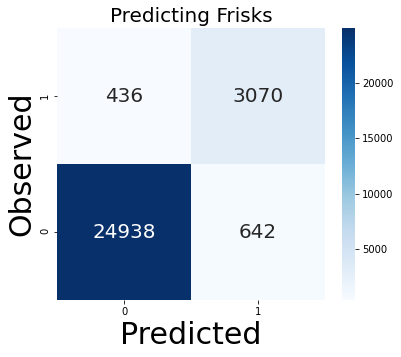

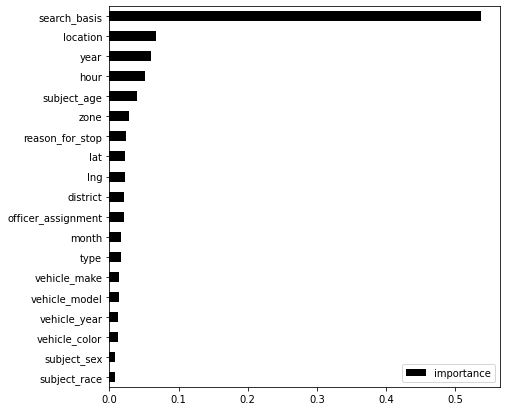

In [67]:
# Predicting Frisks
print("Frisks:")
frisk_test, frisk_pred, feat_imp = rand_for(outcomes['frisk_performed'], 100, 1000)
bin_metrics(frisk_test, frisk_pred)
plot_cm(frisk_test, frisk_pred, 'Predicting Frisks')
feature_importances = pd.DataFrame(feat_imp, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

Searches:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0




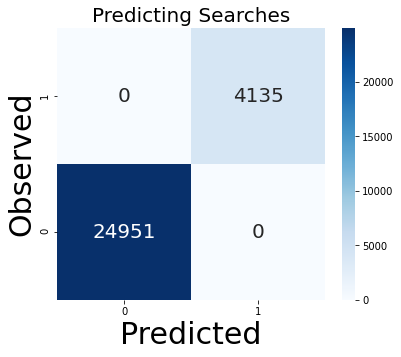

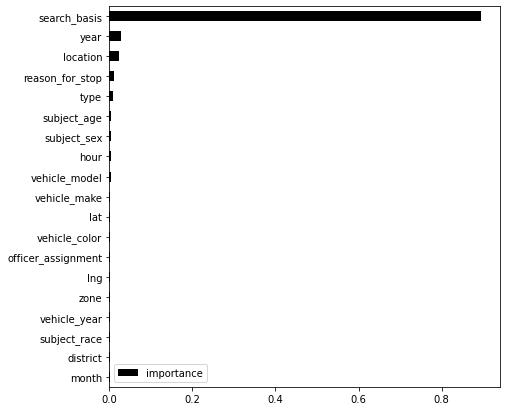

In [68]:
# Predicting Searches
print("Searches:")
search_test, search_pred, feat_imp = rand_for(outcomes['search_conducted'], 100, 1000)
bin_metrics(search_test, search_pred)
plot_cm(search_test, search_pred, 'Predicting Searches')
feature_importances = pd.DataFrame(feat_imp, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

Contraband Found:
Accuracy: 0.9786
Precision: 0.9753
Recall: 0.9786
F1: 0.9744




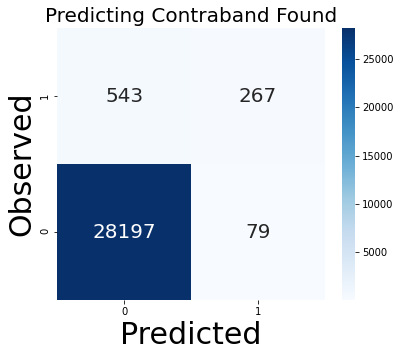

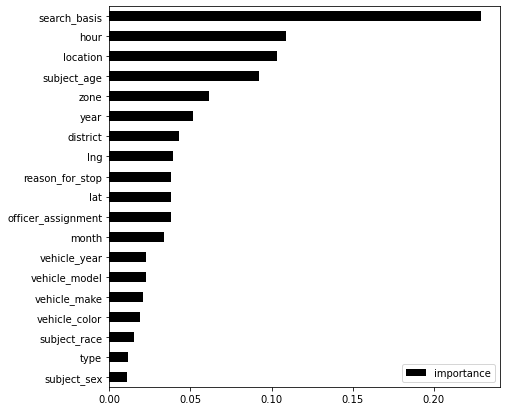

In [69]:
# Predicting Contraband Found
print("Contraband Found:")
contra_test, contra_pred, feat_imp = rand_for(outcomes['contraband_found'], 100, 1000)
bin_metrics(contra_test, contra_pred)
plot_cm(contra_test, contra_pred, 'Predicting Contraband Found')
feature_importances = pd.DataFrame(feat_imp, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

## Adaboost

In [70]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier

def adaboost(outcome_variable, nEst, lrn_rate):
  X_train, X_test, y_train, y_test = train_test_split(feats_rescaled, outcome_variable, test_size=0.20, random_state = 0)
  classifier = AdaBoostClassifier(n_estimators=nEst, learning_rate=lrn_rate)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  feat_weights = classifier.feature_importances_
  return y_test, y_pred, feat_weights

Citations Issued:

Accuracy: 0.789
Precision: 0.7729
Recall: 0.789
F1: 0.7749




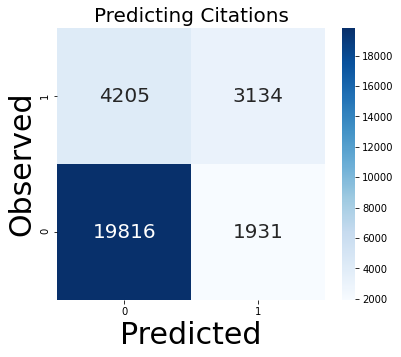

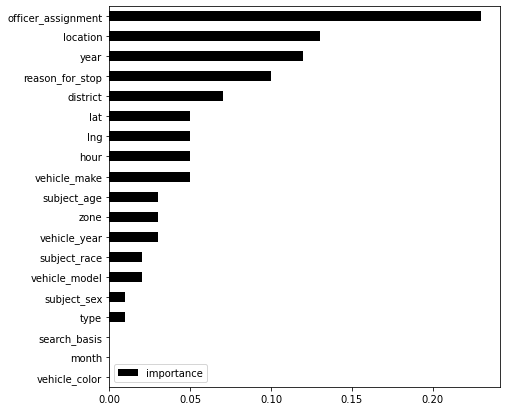

In [71]:
# Predicting citations
print("Citations Issued:\n")
citest_test, cites_pred, feat_imp = adaboost(outcomes['citation_issued'], 100, 1)
bin_metrics(citest_test, cites_pred)
plot_cm(citest_test, cites_pred, 'Predicting Citations')
feature_importances = pd.DataFrame(feat_imp, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

Frisks:

Accuracy: 0.9478
Precision: 0.9484
Recall: 0.9478
F1: 0.948




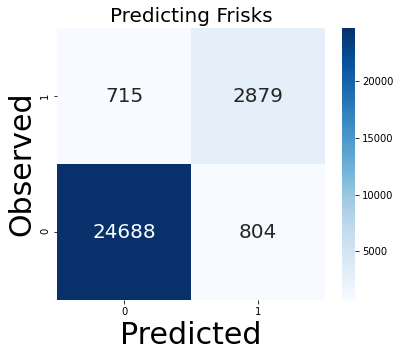

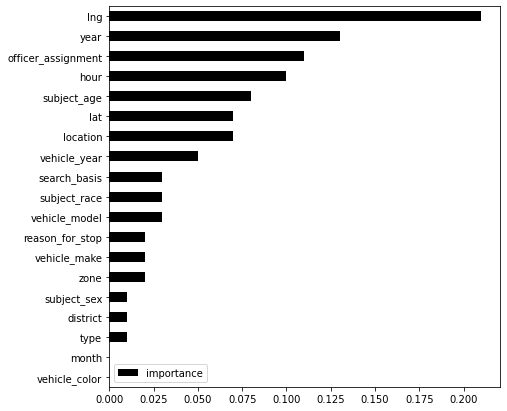

In [72]:
# Predicting Frisks
print("Frisks:\n")
frisks_test, frisks_pred, feat_imp = adaboost(outcomes['frisk_performed'], 100, 1)
bin_metrics(frisks_test, frisks_pred)
plot_cm(frisks_test, frisks_pred, 'Predicting Frisks')
feature_importances = pd.DataFrame(feat_imp, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

Searches:

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0




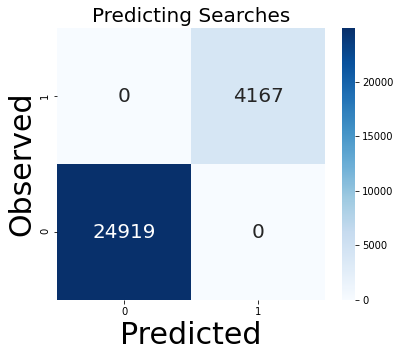

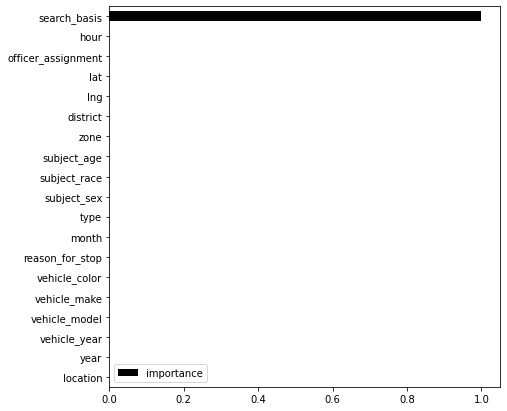

In [73]:
# Predicting Searches
print("Searches:\n")
search_test, search_pred, feat_imp = adaboost(outcomes['search_conducted'], 100, 1)
bin_metrics(search_test, search_pred)
plot_cm(search_test, search_pred, 'Predicting Searches')
feature_importances = pd.DataFrame(feat_imp, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

Contraband Found:

Accuracy: 0.9733
Precision: 0.9659
Recall: 0.9733
F1: 0.9665




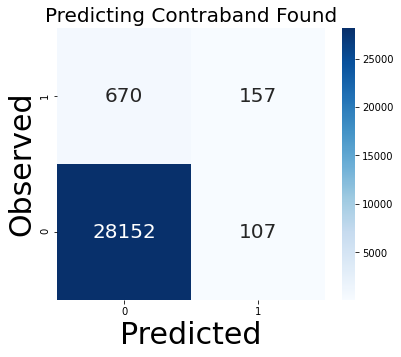

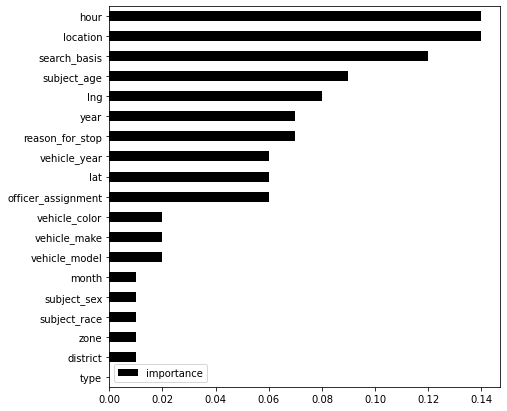

In [74]:
# Predicting Contraband Found
print("Contraband Found:\n")
contra_test, contra_pred, feat_imp = adaboost(outcomes['contraband_found'], 100, 1)
bin_metrics(contra_test, contra_pred)
plot_cm(contra_test, contra_pred, 'Predicting Contraband Found')
feature_importances = pd.DataFrame(feat_imp, index = fr_cols, \
                                    columns=['importance']).sort_values('importance',ascending=True)
feature_importances.plot.barh(rot=0, color='black', figsize=(7, 7))

## Multilayer Perceptron

In [76]:
# Multilayer Perceptron
!pip install eli5
from sklearn.neural_network import MLPClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import StandardScaler

def mlp(outcome_variable, nEst, lrn_rate):
  X_train, X_test, y_train, y_test = train_test_split(feats_rescaled, outcome_variable, test_size=0.20, random_state = 0)
  scaler = StandardScaler()
  train_scaled = scaler.fit_transform(X_train)
  test_scaled = scaler.fit_transform(X_test)
  classifier = MLPClassifier(max_iter = 500)
  clsfr = classifier.fit(train_scaled, y_train)
  perm = PermutationImportance(clsfr).fit(X_test, y_test)
  feat_weights = eli5.show_weights(perm)
  y_pred = classifier.predict(test_scaled)
  return y_test, y_pred, feat_weights

     |████████████████████████████████| 112kB 2.7MB/s 


Using TensorFlow backend.


Citations Issued:

Accuracy: 0.8055
Precision: 0.7966
Recall: 0.8055
F1: 0.7994




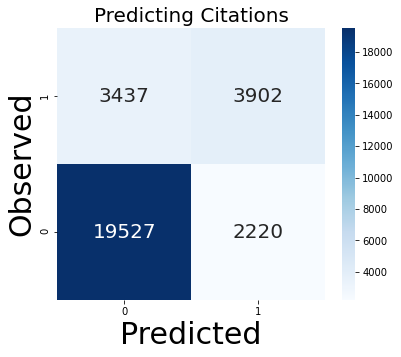

In [77]:
#nEst_range = [10, 50, 100, 1000]
#learning_rate_range = [0.01, 1, 10]

# Predicting citations
print("Citations Issued:\n")
citest_test, cites_pred, feat_imp = mlp(outcomes['citation_issued'], 100, 1)
bin_metrics(citest_test, cites_pred)
plot_cm(citest_test, cites_pred, 'Predicting Citations')

Frisks:

Accuracy: 0.9517
Precision: 0.9521
Recall: 0.9517
F1: 0.9519




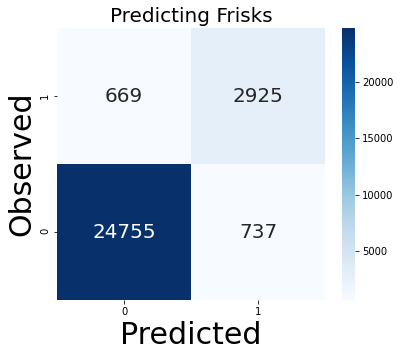

In [78]:
# Predicting Frisks
print("Frisks:\n")
frisks_test, frisks_pred, feat_imp = mlp(outcomes['frisk_performed'], 100, 1)
bin_metrics(frisks_test, frisks_pred)
plot_cm(frisks_test, frisks_pred, 'Predicting Frisks')

Searches:

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0




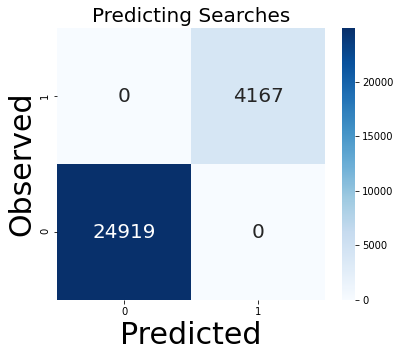

In [79]:
# Predicting Searches
print("Searches:\n")
search_test, search_pred, feat_imp = mlp(outcomes['search_conducted'], 100, 1)
bin_metrics(search_test, search_pred)
plot_cm(search_test, search_pred, 'Predicting Searches')

Contraband Found:

Accuracy: 0.9722
Precision: 0.9667
Recall: 0.9722
F1: 0.9686




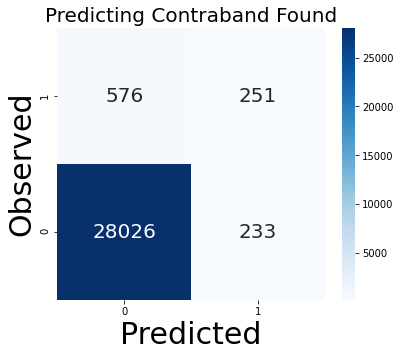

In [80]:
# Predicting Contraband Found
print("Contraband Found:\n")
contra_test, contra_pred, feat_imp = mlp(outcomes['contraband_found'], 100, 1)
bin_metrics(contra_test, contra_pred)
plot_cm(contra_test, contra_pred, 'Predicting Contraband Found')

# Playing with ML plots

In [82]:
nash_ML = pd.read_csv('ML_fits_nash.csv')
nola_ML = pd.read_csv('ML_fits_nola.csv')

In [89]:
nash_ML['city'] = 'nashville'
nola_ML['city'] = 'new_orleans'
all_ml = pd.concat([nash_ML, nola_ML])
all_ml = all_ml.reset_index()
all_ml = all_ml.drop(['index'], axis=1)
all_ml.to_csv('All_ML_fits.csv')

In [93]:
nash_ML

,algorithm,predicting,accuracy,precision,recall,F1,city
0,logistic_regression,citations,0.7856,0.7377,0.7856,0.7003,nashville
1,logistic_regression,frisks,0.9798,0.9599,0.9798,0.9697,nashville
2,logistic_regression,searches,0.9583,0.9195,0.9583,0.9380,nashville
3,logistic_regression,contraband,0.9914,0.9828,0.9914,0.9871,nashville
4,random_forest,citations,0.8520,0.8442,0.8520,0.8352,nashville
5,random_forest,frisks,0.9796,0.9675,0.9796,0.9697,nashville
6,random_forest,searches,0.9602,0.9557,0.9602,0.9432,nashville
7,random_forest,contraband,0.9915,0.9893,0.9915,0.9873,nashville
8,adaboost,citations,0.8041,0.7831,0.8041,0.7552,nashville
9,adaboost,frisks,0.9794,0.9662,0.9794,0.9693,nashville


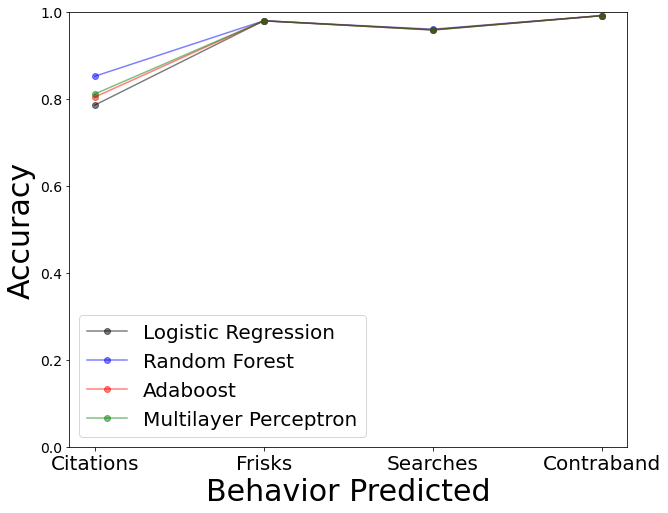

In [112]:
# Plot nashville accuracy by algorithm
x_axis = ['Citations', 'Frisks', 'Searches', 'Contraband']
acc = nash_ML.drop(['precision', 'recall', 'F1'], axis=1)
lr = acc[acc['algorithm']=='logistic_regression'].drop(['algorithm', 'predicting', 'city'], axis=1)
rf = acc[acc['algorithm']=='random_forest'].drop(['algorithm', 'predicting', 'city'], axis=1)
ada = acc[acc['algorithm']=='adaboost'].drop(['algorithm', 'predicting', 'city'], axis=1)
mlp = acc[acc['algorithm']=='multilayer_perceptron'].drop(['algorithm', 'predicting', 'city'], axis=1)

plt.figure(figsize=(10, 8))
plt.plot(x_axis, lr, color='black', marker='o', label='Logistic Regression', alpha=0.5)
plt.plot(x_axis, rf, color='blue', marker='o', label='Random Forest', alpha=0.5)
plt.plot(x_axis, ada, color='red', marker='o', label='Adaboost', alpha=0.5)
plt.plot(x_axis, mlp, color='green', marker='o', label='Multilayer Perceptron', alpha=0.5)
plt.xlabel('Behavior Predicted', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.xticks(fontsize=20)
plt.ylim(0, 1, 0.1)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.show()